# Modelling

### Contents

- [Regression](#1)
	- [Simple Linear Regression](#1)
	- [Boosted Linear Regression](#2)
- [Classification](#3)
	- [Upsampling](#3)
	- [Random Forest](#4)
	- [Multi-Layer Perceptron](#6)
	- [XGBoost](#5)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Bayesian Grid Search 
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score
from sklearn.utils import resample

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [3]:
df10 = pd.read_csv(('../df10.csv'), index_col=[0])

In [4]:
#Considering records >£100 as outliers, variance can't be explained by the data 
df10 = df10[(df10.pound_value <100)]
df10 = df10.dropna()

#i'll need these at the very end
urls = df10[df10.pound_value<100]['url']
df10 = df10.drop(['url'], axis=1)

y = df10['pound_value']
X = df10.loc[:, df10.columns != 'pound_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

<a id="1"></a>
### Simple Linear Regression

test score: 0.338
Intercept: 9.68


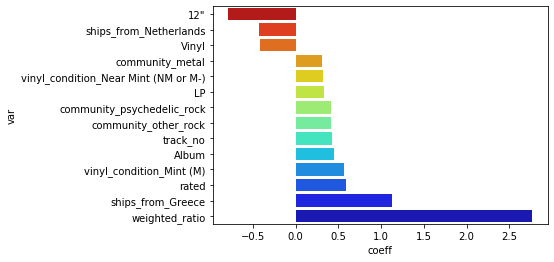

In [148]:
model = ElasticNet()
model.fit(X_train,y_train)

# print('train score:',round(model.score(X_train,y_train),3))
print('test score:',round(model.score(X_test,y_test),3))

print('Intercept:',round(model.intercept_,2))
results = pd.DataFrame({'var': X_train.columns,'coeff': model.coef_})

results2 = results[abs(results.coeff)>0.3].sort_values(by='coeff', ascending=True)

# plt.figure(figsize=(12,8))
ax = sns.barplot(x='coeff', y='var', data=results2, palette='jet_r')
plt.show()

<a id="2"></a>
## Boosted Regression

In [172]:
#df10['pound_value']=[np.log(x) for x in df10.pound_value]

params = {"n_estimators": np.arange(80,200,10),
          "max_depth": np.arange(4,10,1),
          "learning_rate" : np.arange(0.05,0.2,0.01),
          "subsample" : np.arange(0.5,1,0.1)}

gbr = GradientBoostingRegressor()
gbr_search = RandomizedSearchCV(gbr, 
                                param_distributions=params,
                                cv=3,
                                verbose=0, 
                                n_jobs=-1,
                                n_iter=20)

gbr_search.fit(X_train, y_train, sample_weight=None, monitor=None)
print(gbr_search.best_params_)

{'subsample': 0.5, 'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.07}


test score: 0.5352


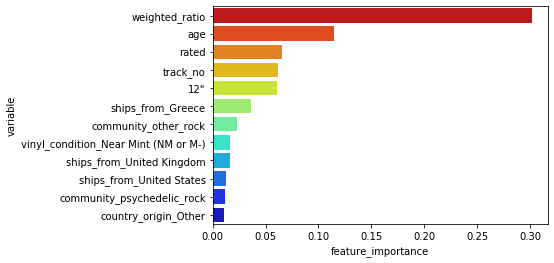

In [175]:
print('test score:',round(gbr_search.score(X_test, y_test),4))

feature_importance = gbr_search.best_estimator_.feature_importances_
variable = X_train.columns

graph = pd.DataFrame({'variable':variable,
                      'feature_importance':feature_importance}).sort_values(by='feature_importance'
                                                                           ,ascending=False).head(12)

ax = sns.barplot(x='feature_importance', y='variable', data=graph, palette='jet_r')
#plt.xticks(rotation=90)
plt.show()

<a id="3"></a>
## Classification
Framing the problem as multi-class price classification, rather than exact prediction

In [5]:
#recreating final dataset
df10 = pd.read_csv(('../df10.csv'), index_col=[0])
df10 = df10[(df10.pound_value <100)]
df10 = df10.dropna()
df10 = df10.drop(['url'], axis=1)

#turning target into a categorical variable
test = []
for i in df10.pound_value:
    if  i <5:
        test.append('a: £0-5.')
    elif i <10:
        test.append('b: £5-10.')
    elif i <20:
        test.append('c: £10-20.')
    elif i <30:
        test.append('d: £20-30.')
    elif i <40:
        test.append('e: £30-40.')
    elif i <50:
        test.append('f: £40-50.')
    elif i <60:
        test.append('g: £50-60.')
    elif i <70:
        test.append('h: £60-70.')
    elif i <100:
        test.append('i: £70-100.')
    else:
        test.append('j: £100-1000000.')
        
df10['pound_value'] = test

print(df10['pound_value'].value_counts())

a: £0-5.       12527
b: £5-10.      10985
c: £10-20.      6232
d: £20-30.      1674
e: £30-40.       757
f: £40-50.       434
i: £70-100.      205
g: £50-60.       196
h: £60-70.       129
Name: pound_value, dtype: int64


## Upsampling

In [6]:
#shuffling
df10 = df10.sample(frac=1).reset_index(drop=True)

#50% train test split
SplitSize = int(len(df10)/2)
train = df10[SplitSize:]
test = df10[:SplitSize]

def upsample(df, baseClass, imbalancedClass):
    base = df[df.pound_value == baseClass]
    imbalanced = df[df.pound_value == imbalancedClass]
    upsampled = resample(imbalanced, replace=True, n_samples=len(base), random_state=123)
    return upsampled

classes = df10['pound_value'].unique()

upsampledDfs = []
for i in classes:
    upsampleData = upsample(train, 'a: £0-5.', i)
    upsampledDfs.append(upsampleData)
    
train = pd.concat(upsampledDfs)

# target labels are fine as they are for XGB
X_train = train.drop(['pound_value'], axis=1)
y_train = train['pound_value']
X_test = test.drop(['pound_value'], axis=1)
y_test = test['pound_value']

# One-Hot Encoding target labels for NN
train['pound_value'] = pd.Categorical(train.pound_value)
train['pound_value'] = train.pound_value.cat.codes
test['pound_value'] = pd.Categorical(test.pound_value)
test['pound_value'] = test.pound_value.cat.codes

train_x = train.drop(['pound_value'], axis=1)
train_y = to_categorical(train.pound_value)
test_x = test.drop(['pound_value'], axis=1)
test_y = to_categorical(test.pound_value)

# scaler = StandardScaler()
# train_x = pd.DataFrame(scaler.fit_transform(train_x),columns=train_x.columns)
# test_y = pd.DataFrame(scaler.transform(test_y),columns=test_y.columns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Baseline

In [134]:
print('baseline:',round(len(df10[df10.pound_value=='a: £0-5.'])/len(df10),4))

baseline: 0.378


<a id="6"></a>
## Neural Network

In [177]:
# implementing 83-128-64-32-9 shaped NN with 20% dropout
model = Sequential()
model.add(Dense(128, input_shape=(83,), activation='relu', kernel_initializer='normal'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu', kernel_initializer='normal'))
model.add(Dropout(.2))
model.add(Dense(32, activation='relu', kernel_initializer='normal'))
model.add(Dropout(.2))
model.add(Dense(9, activation='softmax', kernel_initializer='normal'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fitting with Early Stopping
monitorValAcc = EarlyStopping(monitor='val_accuracy', patience=5)

withCallback = model.fit(train_x, train_y, 
              epochs=100, batch_size=16, 
              validation_data=(test_x, test_y),
              callbacks=[monitorValAcc],
              verbose=0)

accuracy = model.evaluate(test_x, test_y)[1]


Accuracy: 0.553


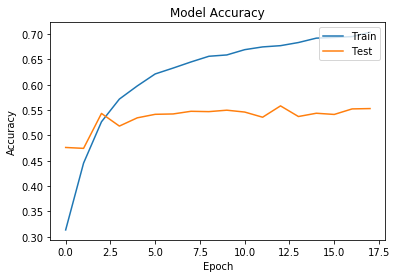

In [179]:
print('')
print('Accuracy:', round(accuracy,4))

plt.figure()
plt.plot(withCallback.history["accuracy"])
plt.plot(withCallback.history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

<a id="5"></a>
## XGBoost - with Bayesian Parameter Optimisation

In [94]:
seed = 2
max_trials = 10

def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    learning_rate = params['learning_rate']
    gamma = params['gamma']
    
    XGB = xgb.XGBClassifier(n_jobs=0,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                       )
    
    eval_set = [(X_test, y_test)]
    
    XGB.fit(X_train, y_train, early_stopping_rounds=5,
            eval_metric="mlogloss", eval_set=eval_set, verbose=False)
    
    pred_y = rf.predict(X_train)
    cv = cross_validate(XGB, X_train, y_train, scoring='accuracy', cv=3)
    score = np.average(cv['test_score'])
    return score

def optimize(trial):
    params={
           'n_estimators' : hp.choice('n_estimators', range(10, 100, 5)),
           'max_depth':hp.uniform('max_depth',10,40),
           'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
           'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
           }
    
    best = fmin(fn=objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=max_trials,
                rstate=np.random.RandomState(seed))
    return best

trial = Trials()
best = optimize(trial)
best

100%|██████████| 10/10 [1:34:06<00:00, 564.67s/trial, best loss: 0.5953286257468767]


{'gamma': 0.3,
 'learning_rate': 0.39,
 'max_depth': 17.42905285316997,
 'n_estimators': 16}

In [12]:
eval_set = [(X_test, y_test)]

XGB = XGBClassifier(n_jobs=0,
                    n_estimators=int(best['n_estimators']),
                    max_depth=int(best['max_depth']),
                    learning_rate=best['learning_rate'],
                    gamma=best['gamma'],
                   )

XGB.fit(X_train, y_train, early_stopping_rounds=5, 
        eval_metric="mlogloss", 
        eval_set=eval_set, verbose=False)

pred_y = XGB.predict(X_test)
print('accuracy:', round(accuracy_score(y_test, pred_y),3))
print(classification_report(y_test, pred_y))

accuracy: 0.569
              precision    recall  f1-score   support

    a: £0-5.       0.73      0.72      0.72      6268
   b: £5-10.       0.57      0.55      0.56      5456
  c: £10-20.       0.46      0.52      0.49      3111
  d: £20-30.       0.25      0.26      0.25       857
  e: £30-40.       0.16      0.15      0.16       387
  f: £40-50.       0.18      0.17      0.18       215
  g: £50-60.       0.07      0.05      0.06       106
  h: £60-70.       0.09      0.08      0.09        64
 i: £70-100.       0.15      0.14      0.15       105

    accuracy                           0.57     16569
   macro avg       0.30      0.29      0.29     16569
weighted avg       0.57      0.57      0.57     16569



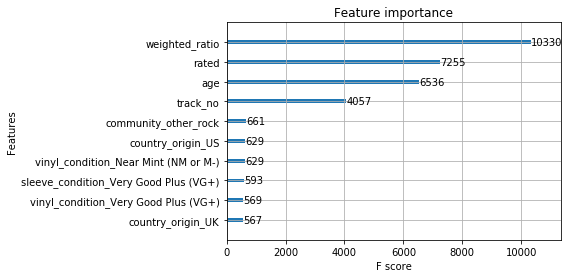

In [23]:
xgb.plot_importance(XGB, max_num_features=10)
plt.show()

## Pickling XGBoost Model for Deployment

In [13]:
# Creating a model with just the 4 most important variables
production_vars = ['weighted_ratio', 'rated', 'age', 'track_no']
eval_set = [(X_test[production_vars], y_test)]

XGB = XGBClassifier(n_jobs=0,
                    n_estimators=16,
                    max_depth=17,
                    learning_rate=0.39,
                    gamma=0.3,
                   )

XGB.fit(X_train[production_vars], y_train, early_stopping_rounds=5, 
        eval_metric="mlogloss", 
        eval_set=eval_set, verbose=False)

pred_y = XGB.predict(X_test[production_vars])
print('accuracy:', round(accuracy_score(y_test, pred_y),3))
print(classification_report(y_test, pred_y))

# Unfortunately this model is now weaker, but entering all of the variables wouldn't make a good user experience
# for a deployed GUI

# Next thing to try will be a GUI where you input a record URL and get a prediction

accuracy: 0.423
              precision    recall  f1-score   support

    a: £0-5.       0.60      0.57      0.59      6357
   b: £5-10.       0.41      0.37      0.39      5441
  c: £10-20.       0.32      0.37      0.34      3090
  d: £20-30.       0.14      0.18      0.16       813
  e: £30-40.       0.09      0.13      0.11       367
  f: £40-50.       0.09      0.08      0.09       229
  g: £50-60.       0.05      0.07      0.06       101
  h: £60-70.       0.07      0.07      0.07        67
 i: £70-100.       0.08      0.08      0.08       104

    accuracy                           0.42     16569
   macro avg       0.21      0.21      0.21     16569
weighted avg       0.44      0.42      0.43     16569



In [15]:
save_path = './'
with open(save_path + 'clf.pickle', 'wb') as outputfile:
    pickle.dump(XGB, outputfile, protocol=4)

In [20]:
test = pd.DataFrame({'weighted_ratio':[1],
              'rated':[2],
              'age':[3],
              'track_no':[4]
             })

XGB.predict(test)



array(['d: £20-30.'], dtype=object)

In [21]:
XGB.predict(test)[0]

'd: £20-30.'